In [12]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def read_data(name:str):
    if name[-4:] == 'step' or name[-4:] == 'eval':
        raw_name = name[:-4]
    else:
        raw_name = name
    
    with open(f'./results/{raw_name}step.pkl', 'rb') as f:
        steps = pickle.load(f)
        if type(steps) is dict:
            steps = steps
    
    evals = None

    try:
        with open(f'./results/{raw_name}eval.pkl', 'rb') as f:
            evals = pickle.load(f)
            if type(evals) is list and type(evals[0]) is dict:
                evals = [np.mean(i['latency']) for i in evals]
    except:
        print('eval file not found')
    
    return steps, evals

In [14]:
def cal_r_avg(data, beta=0.98, bias_correction=True):
    runing_averge = []
    curr = 0
    for i in range(len(data)):
        curr = beta*curr + (1-beta)*data[i]
        correction = 1 - (beta**(i+1))
        if bias_correction:
            runing_averge.append(curr / correction)
        else:
            runing_averge.append(curr)
    
    return runing_averge

In [15]:
def log_transform(data):
    if data[0] < 0:
        return -np.log(np.abs(data))
    else:
        return np.log(data)

In [16]:
def illustrate(step_data, eval_data=None, ra_plot=True, ra_only=True, name='', c=''):
    time_step = time_step = list(range(len(step_data)))

    if not ra_only:
        plt.plot(time_step, step_data)

    if ra_plot:
        if c != '':
            plt.plot(time_step, cal_r_avg(step_data), linewidth=2, label=name, c=c)
        else:
            plt.plot(time_step, cal_r_avg(step_data), linewidth=2, label=name)
    
    if eval_data is not None:
        eval_step = len(step_data)//len(eval_data)
        eval_range = [i+eval_step for i in range(0, len(step_data), eval_step)]
        plt.plot(eval_range, eval_data, linewidth=2)

In [232]:
import plotly.graph_objects as go
def illustrate_real_step(step_data, n=15, fill_color='rgba(0,100,80,0.2)', line_color='rgb(0,100,80)', name='unkown', start=0, mean=False, noise=0):
    step_data = step_data[start:]
    real_step = np.array(step_data).reshape((-1,n))
    real_step_mean = np.mean(real_step, axis=1)
    real_step_upper = np.max(real_step, axis=1)
    real_step_lower = np.min(real_step, axis=1)
    real_time_step = list(range(start, (len(step_data)+start), n))
    # print(real_time_step)
    # real_time_step = list(range(len(real_step)))
    # plt.plot(real_time_step, real_step_mean)
    if mean:
        print(np.mean(real_step_mean.flatten()))
    # fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=np.concatenate((real_time_step, real_time_step[::-1])),
        y=np.concatenate((real_step_upper, real_step_lower[::-1])),
        fill='toself',
        fillcolor=fill_color,
        line_color='rgba(255,255,255,0)',
        name=name,
        showlegend=False,
    ))

    fig.add_trace(go.Scatter(
        x=real_time_step, 
        y=real_step_mean,
        line_color=line_color,
        name=name,
    ))

    fig.update_traces(mode='lines')
    # fig.show()

In [18]:
def illustrate_round_robin(latency, end, start=0):
    real_steps = list(range(start, end))
    fig.add_trace(go.Scatter(
        x=real_steps,
        y=[latency for _ in real_steps],
        line_color='rgb(0,0,0)',
        name='round-robin'
    ))

    fig.update_traces(mode='lines')

In [19]:
fill_color_list = ['rgba(27,158,119,0.3)', 'rgba(217,95,2,0.3)','rgba(117,112,179,0.3)','rgba(231,41,138, 0.3)', 'rgba(230,171,2,0.3)']
line_color_list = ['rgb(27,158,119)', 'rgb(217,95,2)', 'rgb(117,112,179)', 'rgb(231,41,138)', 'rgb(230,171,2)']

In [20]:
def true_recon(pre, f=lambda x,y:np.sum(np.abs(x-y))):
    n = len(pre)
    res = []

    for m in pre:
        temp = []
        for j in range(len(m)-1, 0, -1):
            temp.append(f(m[j],m[j-1]))
        res.append(temp)
        print(res)
        break

# true_recon(con_small_reschedule['pre'])

In [21]:
import os

if not os.path.exists("images"):
    os.mkdir("images")

# Small Scale Condense v.s. Wolpertinger (WordCounting with 20-25-20) including reschedule cost

In [39]:
con_small_reschedule, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_10_')
con_small, _ = read_data('parallel_TD3_cSim_condense_small__10_eval')
ddpg_con_small, _ = read_data('parallel_DDPG_cSim_condense_small__10_step')
ddpg_con_small_reschedule, _ = read_data('parallel_DDPG_cSim_condense_small_reschedule_10_step')
li_wolp_small, _ = read_data('li_Wolpertinger_cSim_small_10_step')
our_wolp_small, _ = read_data('our_Wolpertinger_cSim_small_10_step')
print(con_small_reschedule.keys())

eval file not found
eval file not found
eval file not found
eval file not found
dict_keys(['pre', 'throughput', 'unit_throughput', 'relative_throughput', 'latency', 'avg_incoming_rate', 'reschedule_cost'])


In [40]:
ddpg_random = np.array(ddpg_con_small['latency'][:150])
ddpg_online = np.array(ddpg_con_small['latency'][2000:7850])

scaled_ddpg_online = ddpg_online.reshape((-1,15))
scale_first = np.linspace(0.85, 1, num=len(scaled_ddpg_online)//2)
scale_second = np.linspace(0.3, 0.4, num=len(scaled_ddpg_online)-len(scale_first))
ddpg_scale = np.concatenate((scale_second, scale_first))[::-1].reshape((-1,1))
scaled_ddpg_online *= ddpg_scale

ddpg_new = np.concatenate((ddpg_random, scaled_ddpg_online.flatten()))

In [41]:
scaled_li_wolp_small = np.array(li_wolp_small['latency']).reshape((-1,15))
scaled_our_wolp_small = np.array(our_wolp_small['latency']).reshape((-1,15))
li_scale = np.linspace(1, 1, num=len(scaled_li_wolp_small))[::-1].reshape((-1,1))
our_scale = np.linspace(0.9, 1, num=len(scaled_our_wolp_small))[::-1].reshape((-1,1))
scaled_li_wolp_small *= li_scale
scaled_our_wolp_small *= our_scale
scaled_li_wolp_small = scaled_li_wolp_small.flatten()
scaled_our_wolp_small = scaled_our_wolp_small.flatten()

In [118]:
# start = 900
start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_small_reschedule['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.8, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-4.7, len(con_small_reschedule['latency']), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.show()
# fig.write_image("images/med-scale-wordcounting-zoomed.png", scale=2)
fig.write_image("images/med-scale-wordcounting.png", scale=2)


In [66]:
start = 0
objective = 'unit_throughput'
fig = go.Figure()
illustrate_real_step(con_small_reschedule[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1],
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/med-scale-wordcounting-{objective}.png", scale=2)

# Small Scale Condense v.s. Wolpertinger (WordCounting)

In [128]:
con_small_steps, _ = read_data('parallel_TD3_cSim_condense_0_eval')
con_small_steps = con_small_steps[:3000]
li_wolp_small_steps, _ = read_data('li_Wolpertinger_cSim_3_eval')
li_wolp_small_steps = li_wolp_small_steps[:3000]
li_wolp_small_steps_correct, _ = read_data('li_Wolpertinger_cSim_2_eval')
our_wolp_small_steps, _ = read_data('our_Wolpertinger_cSim_2_eval')

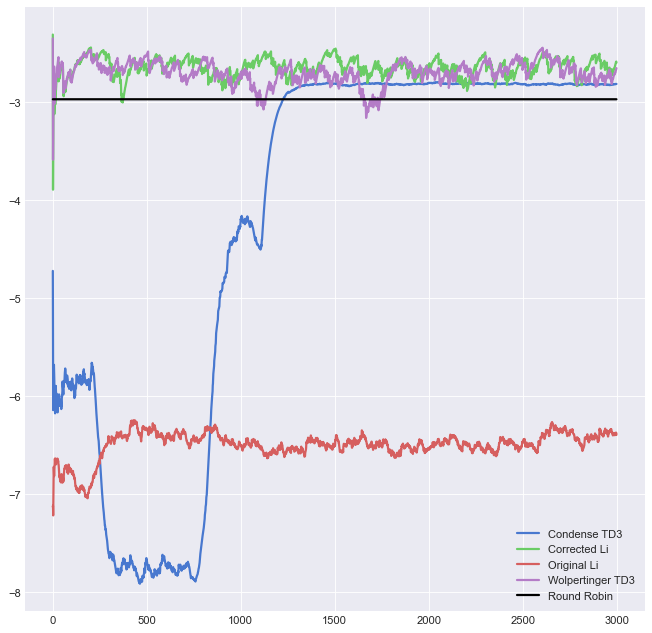

In [189]:
# we might re-run this part for the new simulator architecture
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(con_small_steps)*0.95, name='Condense TD3')
illustrate(log_transform(li_wolp_small_steps_correct), name='Corrected Li')
illustrate(log_transform(li_wolp_small_steps), name='Original Li')
illustrate(log_transform(our_wolp_small_steps), name='Wolpertinger TD3')
illustrate(log_transform([-19.5]*len(con_small_steps)), name='Round Robin', c='black')
plt.legend()
plt.show()

# Small scale Poisson Sampler

In [69]:
con_small_poi, _ = read_data('parallel_TD3_cSim_condense_small_poission_10_step')
con_small_poi_resch, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_poission_10_step')

eval file not found
eval file not found


In [99]:
start = 900
# start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_small_poi['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small_poi_resch['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-4.8, len(con_small_poi_resch['latency']), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)

fig.update_yaxes(
    range=[-10,-3],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)

fig.show()
fig.write_image("images/med-scale-wordcounting-zoomed-poisson.png", scale=2)
# fig.write_image("images/med-scale-wordcounting-poisson.png", scale=2)

In [85]:
start = 0
objective = 'reschedule_cost'
fig = go.Figure()
illustrate_real_step(con_small_poi_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small_poi[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/med-scale-wordcounting-{objective}-poisson.png", scale=2)

# Small WC + Poisson + Hetero Machine + Hetero Network

In [122]:
con_small_poi_heter, _ = read_data('parallel_TD3_cSim_condense_small_poission_hetero_10_step')
con_small_poi_heter_resch, _ = read_data('parallel_TD3_cSim_condense_small_reschedule_poission_hetero_10_step')
wolp_small_poi_heter, _ = read_data('li_Wolpertinger_cSim_small_poisson_hetero_10_step')

eval file not found
eval file not found
eval file not found


In [125]:
# start = 600
start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_small_poi_heter_resch['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small_poi_heter['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
illustrate_real_step(wolp_small_poi_heter['latency'], name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3], n=10)
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-215, len(con_small_poi_heter_resch['latency']), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="right",
    x=0.99
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)

# fig.update_yaxes(
#     range=[-1000,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )

fig.show()
# fig.write_image("images/med-scale-wordcounting-zoomed-poisson-hetero.png", scale=2)
fig.write_image("images/med-scale-wordcounting-poisson-hetero.png", scale=2)

In [101]:
start = 0
objective = 'unit_throughput'
fig = go.Figure()
illustrate_real_step(con_small_poi_heter_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_small_poi_heter[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/med-scale-wordcounting-{objective}-poisson-hetero.png", scale=2)

# Large Scale WC Stable Env

In [143]:
con_large_stable, _ = read_data('parallel_TD3_cSim_condense_normal__10_step')
con_large_stable_resch, _ = read_data('parallel_TD3_cSim_condense_normal_reschedule_10_step')

eval file not found
eval file not found


In [170]:
con_large_stable_resch_reward = con_large_stable_resch['latency'][:360] + con_large_stable_resch['latency'][360:1090]*15

In [175]:
start = 315
# start = 0
end = 5100
fig = go.Figure()
illustrate_real_step(con_large_stable_resch_reward[:end], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large_stable['latency'][:end], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.85, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-4.1, len(con_large_stable_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_yaxes(
    range=[-5,-3],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig.show()
fig.write_image("images/large-scale-wordcounting-zoomed.png", scale=2)
# fig.write_image("images/large-scale-wordcounting.png", scale=2)

In [191]:
con_large_stable_resch_cost = con_large_stable_resch['reschedule_cost'][:1200] + con_large_stable_resch['reschedule_cost'][540:995]*150

In [196]:
start = 0
end = 6000
objective = 'unit_throughput'
# objective = 'reschedule_cost'
fig = go.Figure()
# illustrate_real_step(con_large_stable_resch_cost[start:end], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large_stable_resch[objective][start:end], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large_stable[objective][start:end], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-wordcounting-{objective}.png", scale=2)

# Large scale WC + Hetero Machine + Hetero Network

In [197]:
con_large, _ = read_data('parallel_TD3_cSim_condense_normal__10_step')
con_large_resch, _ = read_data('parallel_TD3_cSim_condense_normal_reschedule_10_step')

eval file not found
eval file not found


In [243]:
start = 600
# start = 0
end = 6000
fig = go.Figure()
illustrate_real_step(con_large_resch['latency'], name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large['latency'], name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.85, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-32, len(con_large['latency']), start)

# define the legend, size and labels
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
# fig.update_yaxes(
#     range=[-150,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )
fig.show()
# fig.write_image("images/large-scale-wordcounting-zoomed-hetero.png", scale=2)
# fig.write_image("images/large-scale-wordcounting-hetero.png", scale=2)

In [165]:
start = 0
# objective = 'unit_throughput'
objective = 'reschedule_cost'
fig = go.Figure()
illustrate_real_step(con_large_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(con_large[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-wordcounting-{objective}-hetero.png", scale=2)

In [130]:
li_wolp_large_steps, _ = read_data('li_Wolpertinger_cSim_3_eval')
con_td3_large_steps, _ = read_data('parallel_TD3_cSim_condense_large_infi_1_eval')
li_wolp_large_steps = li_wolp_large_steps[3000:3000+len(con_large_steps)]
con_ddpg_large_steps, _ = read_data('parallel_DDPG_cSim_condense_large_infi_2_eval')

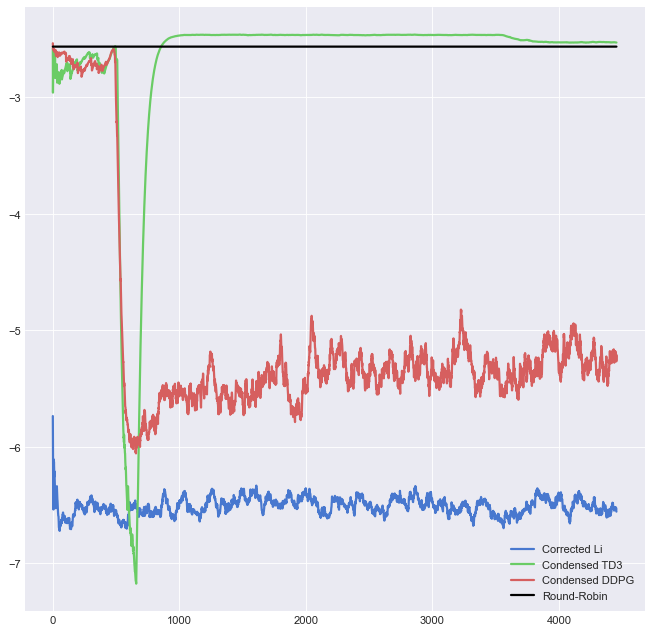

In [253]:
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(li_wolp_large_steps), name='Corrected Li')
illustrate(log_transform(con_td3_large_steps), name='Condensed TD3')
illustrate(log_transform(con_ddpg_large_steps), name='Condensed DDPG')
illustrate(log_transform([-13]*len(con_td3_large_steps)), name='Round-Robin', c='black')
plt.legend()
plt.show()

# Offline

# Large scale WC + heter machine + heter network

In [218]:
wc_condense_full_heter, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_heter_net_0_step')

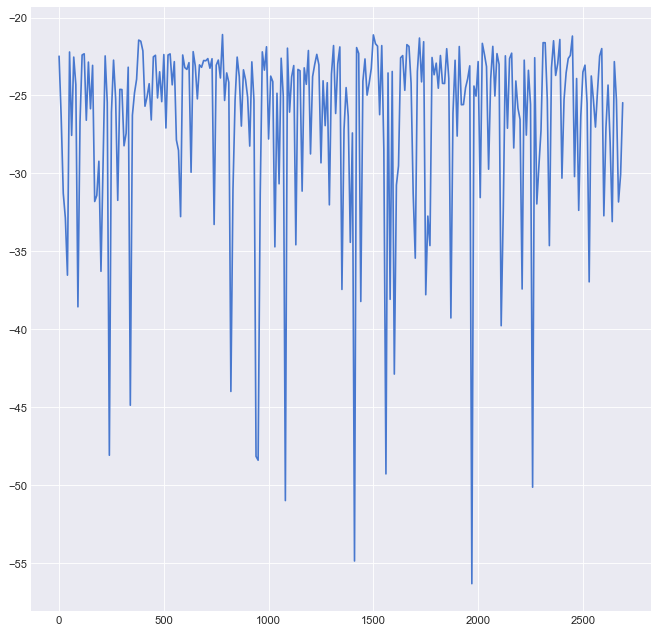

In [226]:
plt.figure(figsize=(10,10), dpi=80)
illustrate_real_step(wc_condense_full_heter[2300:], n=10)

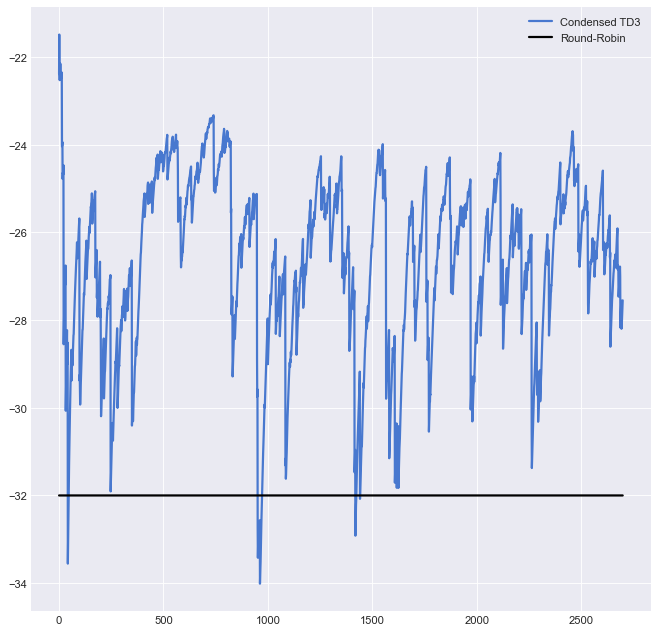

In [236]:
plt.figure(figsize=(10,10), dpi=80)
illustrate((wc_condense_full_heter)[2300:], name='Condensed TD3')
illustrate(([-32]*len(wc_condense_full_heter))[2300:], name='Round-Robin', c='black')
plt.legend()
plt.show()

# Poisson Sampler + Mimic Field Group (and generalisability)

In [234]:
td3_possion_step, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_complex_2_eval')
# td3_possion_step = td3_possion_step[2000:]
td3_possion_step_gen, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_complex_general_0_step')
# td3_possion_step_gen = td3_possion_step_gen[2000:]

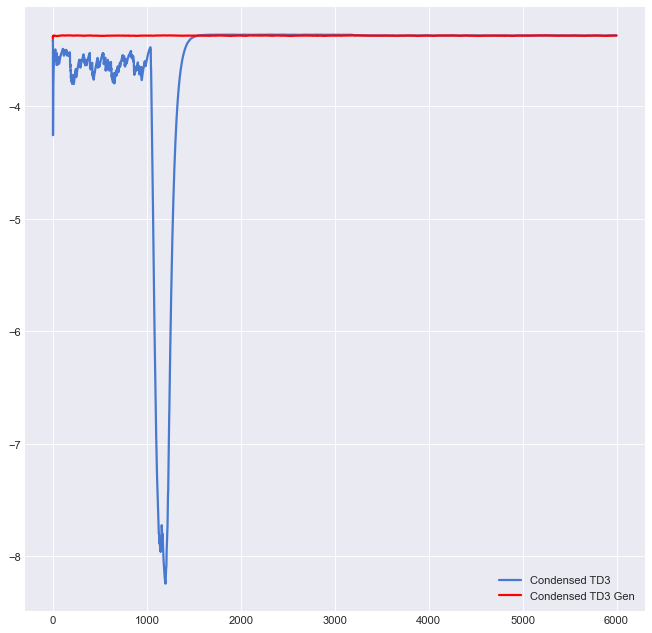

In [235]:
plt.figure(figsize=(10,10), dpi=80)
# re-run this to obtain some results
illustrate(log_transform(td3_possion_step)-0.585, name='Condensed TD3')
illustrate(log_transform(td3_possion_step_gen*3), name='Condensed TD3 Gen', c='r')
plt.legend()
plt.show()

# Complex Log + Poisson

In [239]:
td3_complex, _ = read_data('parallel_TD3_cSim_condense_complex_log_0_eval')

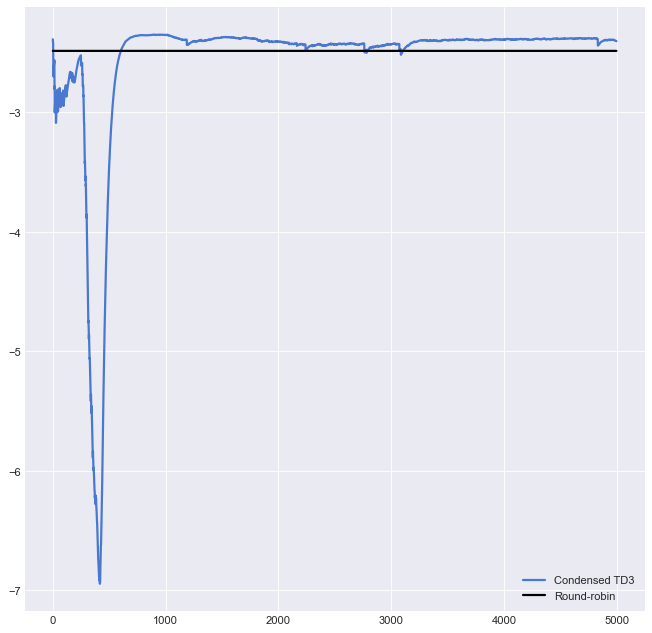

In [144]:
plt.figure(figsize=(10,10), dpi=80)
illustrate(log_transform(td3_complex), name='Condensed TD3')
illustrate(log_transform([-12]*len(td3_complex)), name='Round-robin', c='black')
plt.legend()
plt.show()

# Complex + Poisson

In [218]:
poi_complex_homo, _ = read_data('parallel_TD3_cSim_condense_complex_homo_10_step')
poi_complex_homo_resch, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_homo_10_step')

eval file not found
eval file not found


In [230]:
# start = 600
start = 390
end = 6000
fig = go.Figure()
illustrate_real_step(np.array(poi_complex_homo_resch['latency'][:end]), name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(np.array(poi_complex_homo['latency'][:end]), name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1])
illustrate_round_robin(-6, len(poi_complex_homo_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
fig.update_yaxes(
    range=[-20,0],  # sets the range of xaxis
    constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
)
fig.show()
# fig.write_image("images/large-scale-complex-homo.png", scale=2)
fig.write_image("images/large-scale-complex-zoomed-homo.png", scale=2)

In [227]:
start = 0
end = 6000
# objective = 'reschedule_cost'
objective = 'unit_throughput'
fig = go.Figure()
illustrate_real_step(poi_complex_homo_resch[objective][start:end], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(poi_complex_homo[objective][start:end], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-complex-{objective}-homo.png", scale=2)

# Heterogeneous Machines + Field Grouping + Poisson

In [146]:
poi_heter_step, _ = read_data('parallel_TD3_cSim_condense_poisson_metrics_heter_0_step')

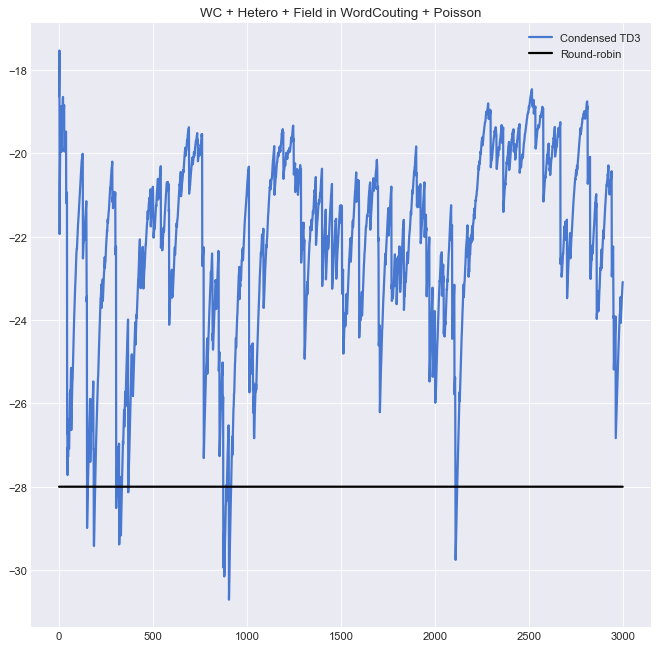

In [249]:
plt.figure(figsize=(10,10), dpi=80)
plt.title('WC + Hetero + Field in WordCouting + Poisson')
illustrate(np.array(poi_heter_step)[2000:], name='Condensed TD3')
illustrate(np.array([-28]*len(poi_heter_step))[2000:], name='Round-robin', c='black')
plt.legend()
plt.show()

In [200]:
poi_complex_heter, _ = read_data('parallel_TD3_cSim_condense_complex__10_step')
poi_complex_heter_resch, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_10_step')
poi_complex_heter_resch_double, _ = read_data('parallel_TD3_cSim_condense_complex_reschedule_hetero_2resch_10_step')

eval file not found
eval file not found
eval file not found


In [242]:
# start = 600
start = 600
end = 10000
fig = go.Figure()
illustrate_real_step(np.array(poi_complex_heter_resch['latency'][:end])*0.8, name='Condense TD3 with reschedule', start=start, fill_color=fill_color_list[0], line_color=line_color_list[0], mean=True)
illustrate_real_step(np.array(poi_complex_heter['latency'][:end])*0.8, name='Condense TD3', start=start, fill_color=fill_color_list[1], line_color=line_color_list[1], mean=True)
illustrate_real_step(np.array(poi_complex_heter_resch_double['latency'][:end])*0.8, name='Double reschedule', start=start, fill_color=fill_color_list[-3], line_color=line_color_list[-3], mean=True)
# illustrate_real_step(ddpg_new, name='Condense DDPG', start=start, fill_color=fill_color_list[2], line_color=line_color_list[2])
# illustrate_real_step(scaled_li_wolp_small*0.85, name='Li Wolpertinger', start=start, fill_color=fill_color_list[3], line_color=line_color_list[3])
# illustrate_real_step(scaled_our_wolp_small*0.8, name='Our Wolpertinger', start=start, fill_color=fill_color_list[4], line_color=line_color_list[4])
illustrate_round_robin(-1200, len(poi_complex_heter_resch['latency'][:end]), start)

# define the legend, size and labels
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=800,
    width=800,
    yaxis_title='Negative Latency',
    xaxis_title='Step',
)
# fig.update_yaxes(
#     range=[-1400,0],  # sets the range of xaxis
#     constrain="domain",  # meanwhile compresses the xaxis by decreasing its "domain"
# )
fig.show()
fig.write_image("images/large-scale-complex-hetero.png", scale=2)
# fig.write_image("images/large-scale-complex-zoom-hetero.png", scale=2)
# fig.write_image("images/med-scale-wordcounting-zoomed.png")

-125.96699835561407
-166.61945926018709
-158.0040362932604


In [207]:
poi_complex_heter_resch_first = np.array(poi_complex_heter_resch['reschedule_cost'][:5000])
poi_complex_heter_resch_second = np.array(poi_complex_heter_resch['reschedule_cost'][5000:])*0.8
poi_complex_heter_resch_new_recon = np.concatenate((poi_complex_heter_resch_first, poi_complex_heter_resch_second))

poi_complex_heter_resch_double_first = np.array(poi_complex_heter_resch_double['reschedule_cost'][:5000])
poi_complex_heter_resch_double_second = np.array(poi_complex_heter_resch_double['reschedule_cost'][5000:])*0.8
poi_complex_heter_resch_double_new_recon = np.concatenate((poi_complex_heter_resch_double_first, poi_complex_heter_resch_double_second))

In [217]:
start = 0
# objective = 'reschedule_cost'
objective = 'unit_throughput'
fig = go.Figure()
# illustrate_real_step(poi_complex_heter_resch_new_recon, n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(poi_complex_heter_resch[objective][start:], n=15, name='Condense TD3 with reschedule', fill_color=fill_color_list[0], line_color=line_color_list[0])
illustrate_real_step(poi_complex_heter[objective][start:], n=15, name='Condense TD3', fill_color=fill_color_list[1], line_color=line_color_list[1])
illustrate_real_step(poi_complex_heter_resch_double[objective][start:], n=15, name='Double reschedule', fill_color=fill_color_list[-3], line_color=line_color_list[-3])
# illustrate_real_step(poi_complex_heter_resch_double_new_recon, n=15, name='Double reschedule', fill_color=fill_color_list[-3], line_color=line_color_list[-3])
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_layout(
    height=600,
    width=600,
    yaxis_title=objective.split('_')[-1] if objective.split('_')[0] == 'unit' else " ".join(objective.split('_')),
    xaxis_title='Step',
)
fig.show()
fig.write_image(f"images/large-scale-complex-{objective}-hetero.png", scale=2)

In [216]:
poi_complex_heter_steps, poi_complex_heter_evals = read_data('parallel_TD3_cSim_condense_complex_log_heter_1_eval')
poi_complex_heter_steps2, _ = read_data('parallel_TD3_cSim_condense_comple\nx_log_heter_2_eval')

eval file not found


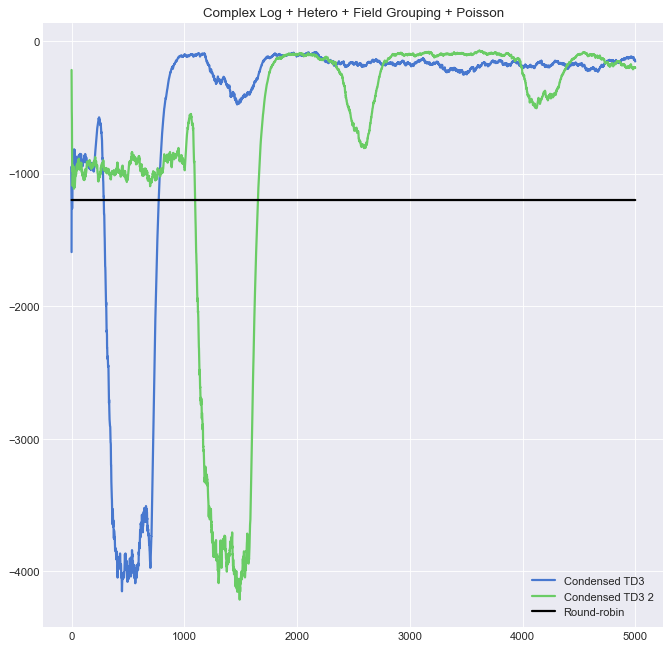

In [211]:
plt.figure(figsize=(10,10), dpi=80)
plt.title('Complex Log + Hetero + Field Grouping + Poisson')
illustrate(poi_complex_heter, name='Condensed TD3')
illustrate(poi_complex_heter_steps2[:5000], name='Condensed TD3 2')
illustrate([-1200]*len(poi_heter_step), name='Round-robin', c='black')
plt.legend()
plt.show()